In [73]:
import pinocchio as pin
import numpy as np

from pinocchio.visualize import MeshcatVisualizer
import hppfcl
import time

In [74]:
np.random.seed(0)

## Utility functions

In [ ]:
def simulate_inverted_pendulum(model, physical_params, simulation_time, dt, verbose=False):
    init_q, init_v, damping_coeff = physical_params  # initial angle, angular velocity and damping coefficient

    # Create data for the model
    data = model.createData()

    # Set initial state (angle and angular velocity)
    # q is the joint configuration (angle in radians)
    # v is the joint velocity (angular velocity in rad/s)
    q = np.array([init_q])
    v = np.array([init_v])

    # Store trajectory data
    trajectory = []
    times = []

    # Simulation loop
    num_steps = int(simulation_time / dt)
    for i in range(num_steps):
        trajectory.append(q.copy())
        times.append(i * dt)

        tau = np.array([-damping_coeff * v * length])
        a = pin.aba(model, data, q, v, tau)

        v += a * dt
        q = pin.integrate(model, q, v * dt)

        if verbose:
            print(f"Time: {times[-1]:.3f}s, Angle: {q[0]:.3f} rad, Angular Vel: {v[0]:.3f} rad/s")

    return trajectory, times

In [667]:
def visualize_inverted_pendulum(model, trajectory, dt):
    
    viz = MeshcatVisualizer(model, geom_model, geom_model)
    viz.initViewer(open=True)
    viz.loadViewerModel()

    print("Starting visualization...")
    for q_viz in trajectory:
        viz.display(q_viz)
        time.sleep(dt)
    print("Visualization finished.")

In [ ]:
def plot_most_similar(latents, pt, num, ax):
    "Plot the trajectories that have the num closest latents to pt."
    dists = np.linalg.norm(latents - pt, axis=1)
    closest_idxs = np.argsort(dists)[:num]
    for idx in closest_idxs:
        ax.plot(simulation_times, trajs[idx, :], alpha=.3)

## Simulation

In [889]:
model = pin.Model()

mass = 1.0  # kg
length = 1.0 # meters

joint_id = model.addJoint(0, 
                          pin.JointModelRX(), 
                          pin.SE3.Identity(), 
                          "pendulum_joint"
                        )

inertia = pin.Inertia(mass,
                      np.array([0., 0., length / 2]),
                      pin.Inertia.FromCylinder(mass, length / 20, length).inertia)
model.appendBodyToJoint(joint_id, 
                        inertia,
                        pin.SE3.Identity())

model.gravity.linear[2] = -9.81

In [890]:
geom_model = pin.GeometryModel()
cylinder_placement = pin.SE3(np.eye(3), np.array([0., 0., length / 2]))

cylinder = pin.GeometryObject(
    "pendulum_cylinder",
    joint_id,
    joint_id,
    cylinder_placement,
    hppfcl.Cylinder(length/20, length)
)
cylinder.meshColor = np.array([1.0, 0.0, 0.0, 1.0]) # RGBA (red)
geom_model.addGeometryObject(cylinder)

0

In [638]:
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer(open=True)
viz.loadViewerModel()
viz.display(np.array([0.]))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


Inverted Pendulum Model created successfully.
Number of joints: 1
Simulating for 10.0 seconds with a time step of 0.01...
Simulation complete.
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
Starting visualization...
Visualization finished.


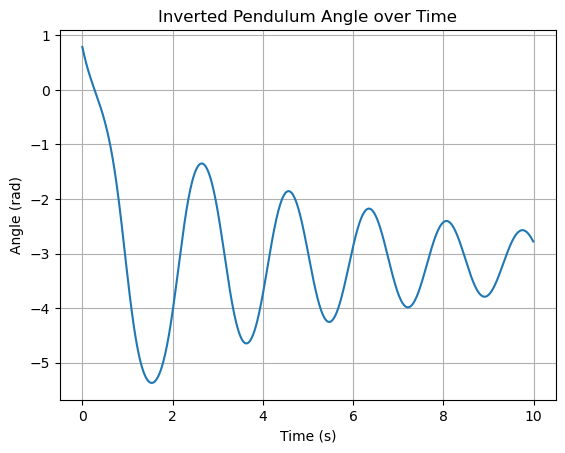

In [643]:
# Create the inverted pendulum model
pendulum_model = model
print("Inverted Pendulum Model created successfully.")
print(f"Number of joints: {pendulum_model.nq}")

# Simulation parameters
params = (np.pi/4, -4., .1)

simulation_duration = 10.0      # seconds
time_step = 0.01             # seconds

# Simulate the pendulum
print(f"Simulating for {simulation_duration} seconds with a time step of {time_step}...")
pendulum_trajectory, simulation_times = simulate_inverted_pendulum(
    pendulum_model, params, simulation_duration, time_step
)
print("Simulation complete.")

# Visualize the simulation
visualize_inverted_pendulum(pendulum_model, pendulum_trajectory, time_step)

# You can also plot the results if you have matplotlib
try:
    import matplotlib.pyplot as plt
    angles = [q[0] for q in pendulum_trajectory]
    plt.plot(simulation_times, angles)
    plt.title("Inverted Pendulum Angle over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (rad)")
    plt.grid(True)
    plt.show()
except ImportError:
    print("Matplotlib not found. Skipping plotting.")

## Generating the trajectories

In [345]:
from sklearn.preprocessing import normalize

In [891]:
n_simulations = 20_000

simulation_duration = 10.
time_step = .1

trajs = []

for i in range(n_simulations):

    q = np.random.uniform(-np.pi, np.pi)
    v = np.random.uniform(-6, 6)
    b = np.random.uniform(0, .2)
    params = (q, v, b)

    traj, simulation_times = simulate_inverted_pendulum(
        model, params, simulation_duration, time_step
    )
    trajs.append(traj)

trajs = np.array(trajs).reshape(n_simulations, -1)

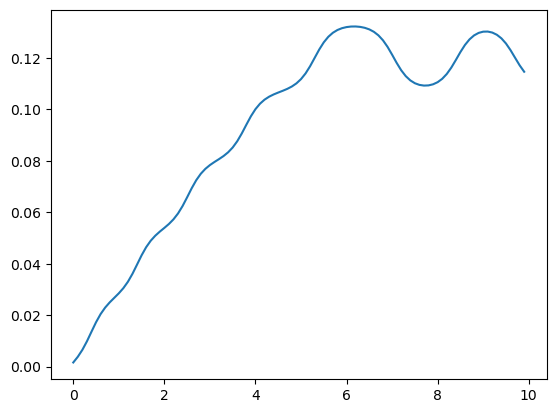

In [774]:
plt.plot(simulation_times, trajs[200, :])

In [968]:
trajs = normalize(trajs)  # option 1: normalize
#trajs = np.mod(trajs, 2 * np.pi)  # option 2: remainder mod 2pi

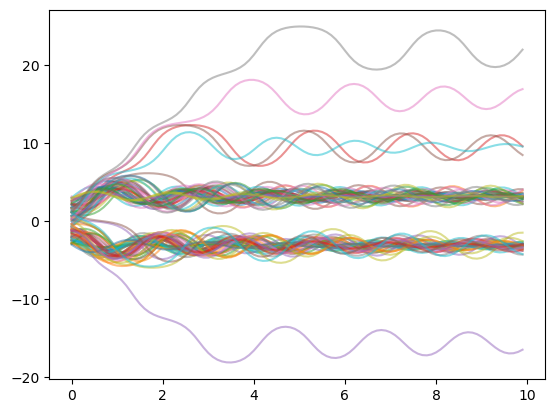

In [895]:
for i in range(100):
    plt.plot(simulation_times, trajs[i], alpha=.5)
plt.savefig('some_trajs')

## Learning a representation for trajectories

In [266]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [783]:
X = torch.tensor(trajs).to(torch.float32)
dl = DataLoader(X, batch_size=128)

### MLP

In [837]:
class TrajEnc(nn.Module):

    def __init__(self, input_dim, latent_dim):
        super(TrajEnc, self).__init__()

        self.enc = nn.Sequential(
            nn.Linear(input_dim, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, latent_dim)
        )

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 60),
            nn.ReLU(),
            nn.Linear(60, input_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        u = self.enc(x)
        return 2 * self.dec(u) - 1, u


In [838]:
te = TrajEnc(100, 2)

opt = optim.Adam(te.parameters(), lr=.0002)
#sched = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

loss_fn = nn.MSELoss()

print(f'# params: {sum(p.numel() for p in te.parameters())}')

# params: 18822


In [839]:
n_epochs = 200

for epoch in range(n_epochs):
    epoch_loss = 0.0
    
    # Iterate over batches of data
    for batch_idx, x in enumerate(dl):

        opt.zero_grad()
        rec, lat = te(x)
        loss = loss_fn(rec, x)
        loss.backward()

        opt.step()

        epoch_loss += loss.item() * x.size(0) 

    avg_epoch_loss = epoch_loss / len(dl.dataset)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}")
    #sched.step(avg_epoch_loss)

Epoch [10/200], Loss: 0.0005
Epoch [20/200], Loss: 0.0004
Epoch [30/200], Loss: 0.0004
Epoch [40/200], Loss: 0.0003
Epoch [50/200], Loss: 0.0002
Epoch [60/200], Loss: 0.0002
Epoch [70/200], Loss: 0.0002
Epoch [80/200], Loss: 0.0002
Epoch [90/200], Loss: 0.0002
Epoch [100/200], Loss: 0.0001
Epoch [110/200], Loss: 0.0001
Epoch [120/200], Loss: 0.0001
Epoch [130/200], Loss: 0.0001
Epoch [140/200], Loss: 0.0001
Epoch [150/200], Loss: 0.0001
Epoch [160/200], Loss: 0.0001
Epoch [170/200], Loss: 0.0001
Epoch [180/200], Loss: 0.0001
Epoch [190/200], Loss: 0.0001
Epoch [200/200], Loss: 0.0001


In [840]:
with torch.no_grad():
    _, latents = te(X)

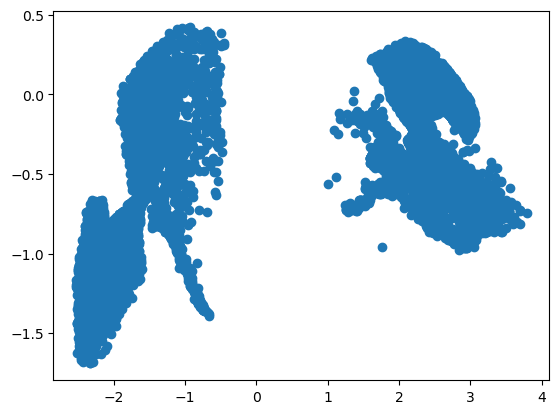

In [841]:
plt.scatter(*latents.numpy().T)

/var/folders/c2/vhmqh4t566q95zcjystvh20c0000gn/T/ipykernel_5962/3640923070.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dists = np.linalg.norm(latents - pt, axis=1)


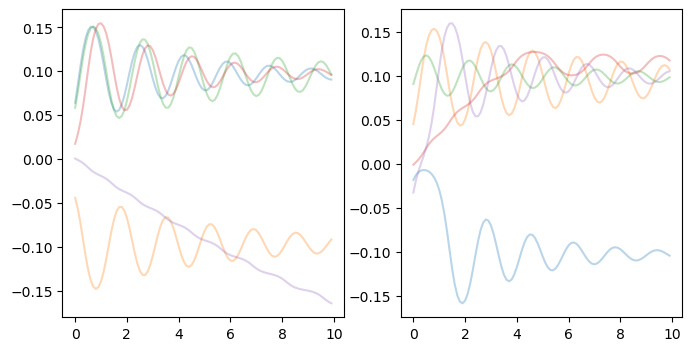

In [846]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plot_most_similar(latents, np.array([-1., 0]), 5, axs[0])
plot_most_similar(latents, np.array([3., -0.5]), 5, axs[1])

In [847]:
with torch.no_grad():
    rec = te.dec(latents)

In [894]:
for i in range(100):
    plt.plot(simulation_times, rec.numpy()[i], alpha=.5)
plt.savefig('some_rec_trajs')

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

6302


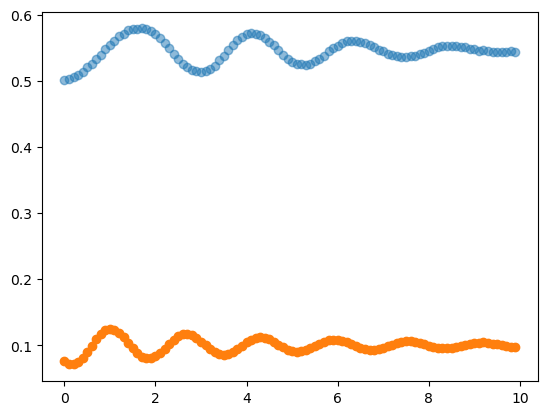

In [878]:
i = np.random.choice(range(len(trajs)))
plt.scatter(simulation_times, rec.numpy()[i], alpha=.5)
plt.scatter(simulation_times, trajs[i])
print(i)

The reconstructions are a bit lossy, but do a good job of mapping similar trajectories to similar latents.

But this approach doesn't seem like it'll work, since the latent of a traj shouldn't depend on the number of revolutions that it has already undergone. The "history" of a trajectory shouldn't matter that much.

The negative trajectories are represented badly.

In [767]:
with torch.no_grad():
    outlier = te.dec(torch.tensor([[-10, 10]]).to(torch.float))

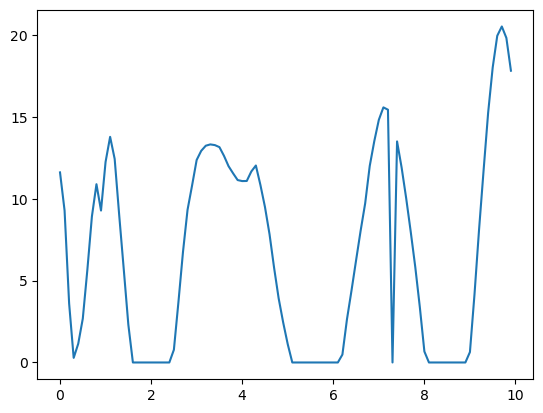

In [770]:
plt.plot(simulation_times, outlier[0].numpy())

### 1D Convolution

In [926]:
class ConvAutoencoder1D(nn.Module):
    def __init__(self, input_features, sequence_length, latent_dim=2):
        super(ConvAutoencoder1D, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(input_features, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, latent_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Calculate the output sequence length after encoding
        # Formula for Conv1d output length: L_out = floor((L_in + 2*padding - dilation*(kernel_size-1) - 1)/stride) + 1
        # For first layer: L1 = floor((sequence_length + 2*1 - 1*(3-1) - 1)/2) + 1 = floor((sequence_length + 2 - 2 - 1)/2) + 1 = floor((sequence_length - 1)/2) + 1
        # For second layer: L2 = floor((L1 + 2*1 - 1*(3-1) - 1)/2) + 1 = floor((L1 - 1)/2) + 1
        # To simplify, let's just make sure the decoder can roughly inverse the operations.
        # A common approach is to compute this dynamically or use a fixed small size and then interpolate/pad if needed.
        # For simplicity and small examples, integer division often works well.
        # Example: if sequence_length = 100
        # L1 = floor((100 - 1)/2) + 1 = 49 + 1 = 50
        # L2 = floor((50 - 1)/2) + 1 = 24 + 1 = 25
        # So, the effective sequence length in latent space will be (sequence_length // 4) or so.
        # Let's directly calculate based on input sequence_length
        self._encoded_seq_len = sequence_length
        for _ in range(2): # Number of conv layers in encoder with stride 2
            self._encoded_seq_len = (self._encoded_seq_len + 2*1 - (3-1) - 1) // 2 + 1 # kernel=3, stride=2, padding=1

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(latent_dim, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, input_features, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Ensure output matches original sequence length and features if needed
        # Due to integer division and padding, output_padding might need adjustment or final slicing/padding
        if decoded.shape[2] != x.shape[2]:
            decoded = decoded[:, :, :x.shape[2]] # Simple slicing if output is slightly larger
        return decoded, encoded

In [939]:
conv = ConvAutoencoder1D(1, 100)
opt = optim.Adam(conv.parameters(), lr=0.0001)

In [928]:
print(f'num params: {sum(p.numel() for p in conv.parameters())}')

num params: 2563


In [940]:
n_epochs = 20

for epoch in range(n_epochs):
    epoch_loss = 0.0
    
    # Iterate over batches of data
    for batch_idx, x in enumerate(dl):
        bs = x.size(0)
        x = x.view(bs, 1, -1)

        opt.zero_grad()
        rec, lat = conv(x)
        loss = loss_fn(rec, x)
        loss.backward()

        opt.step()

        epoch_loss += loss.item()
    
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}")
    #sched.step(avg_epoch_loss)

Epoch [1/20], Loss: 1.2482
Epoch [2/20], Loss: 0.0742
Epoch [3/20], Loss: 0.0205
Epoch [4/20], Loss: 0.0157
Epoch [5/20], Loss: 0.0127
Epoch [6/20], Loss: 0.0103
Epoch [7/20], Loss: 0.0083
Epoch [8/20], Loss: 0.0067
Epoch [9/20], Loss: 0.0051
Epoch [10/20], Loss: 0.0040
Epoch [11/20], Loss: 0.0033
Epoch [12/20], Loss: 0.0028
Epoch [13/20], Loss: 0.0025
Epoch [14/20], Loss: 0.0024
Epoch [15/20], Loss: 0.0022
Epoch [16/20], Loss: 0.0021
Epoch [17/20], Loss: 0.0020
Epoch [18/20], Loss: 0.0019
Epoch [19/20], Loss: 0.0018
Epoch [20/20], Loss: 0.0017


In [944]:
with torch.no_grad():
    rec, latents = conv(X.reshape(20_000, 1, 100))

rec = rec.view(len(trajs), -1)

In [945]:
latents.shape

torch.Size([20000, 2, 25])

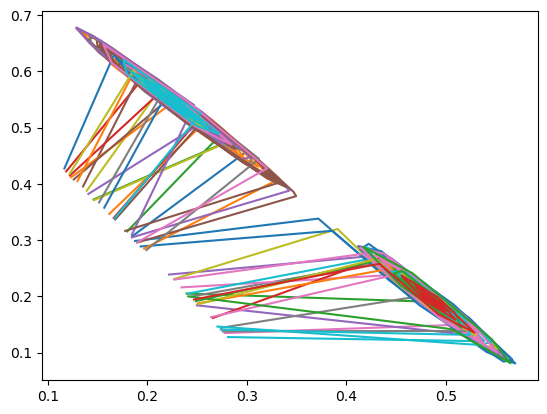

In [953]:
for idx, traj_lat in enumerate(latents[:50].numpy()):
    plt.plot(traj_lat[0], traj_lat[1])

/var/folders/c2/vhmqh4t566q95zcjystvh20c0000gn/T/ipykernel_5962/3640923070.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dists = np.linalg.norm(latents - pt, axis=1)


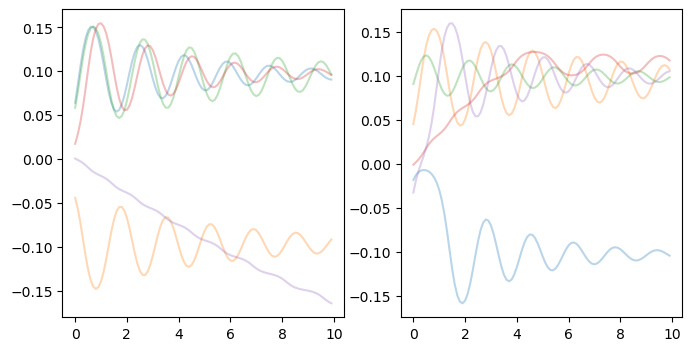

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plot_most_similar(latents, np.array([-1., 0]), 5, axs[0])
plot_most_similar(latents, np.array([3., -0.5]), 5, axs[1])

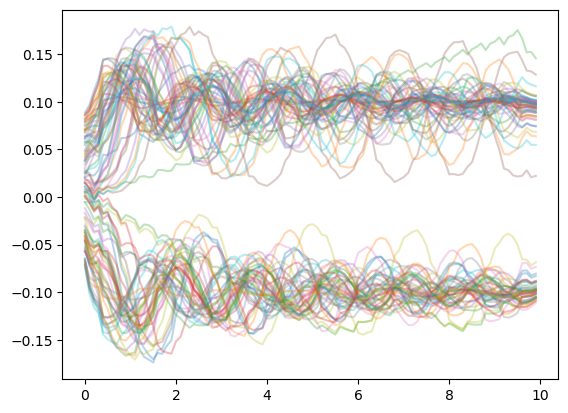

In [969]:
for i in range(100):
    plt.plot(simulation_times, rec.numpy()[i], alpha=.3)
plt.savefig('some_rec_trajs')

12641


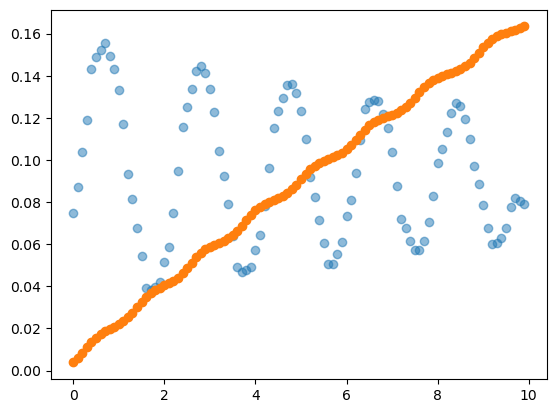

In [994]:
i = np.random.choice(range(len(trajs)))
plt.scatter(simulation_times, rec.numpy()[i], alpha=.5)
plt.scatter(simulation_times, trajs[i])
print(i)